In [1]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from particle_filter import particlefilter
from models import SEIR_model,SEIR_Obs
from pmcmc import pmcmc_validator
from scipy.stats import norm

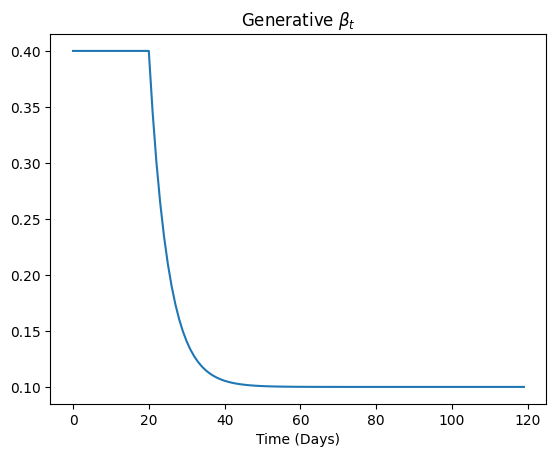

In [2]:
'''Simulated Data, setting up the SIR model'''

rng = np.random.default_rng(0)

gamma = 1/14
eta = 1/7
q = 0.1
mu = 0.004
rho = 0.1

T = 120
dt = 1.
t_vec = np.arange(0,T,dt)

N = 100_000
I = 5
E = 5


beta_par = {'b_0':0.4,'b_inf': 0.1, 'tau': 5,'T':20}

def beta_sim(par,t):
    if(t < par['T']):
        return 0.4
    
    return par['b_inf'] + (par['b_0'] - par['b_inf']) * np.exp(-(t - par['T'])/par['tau'])

betas = np.array([beta_sim(beta_par,t) for t in t_vec])

state = np.zeros((5,len(t_vec)))
state[:,0] = np.array([N - I - E,E, I, 0,0])

plt.title('Generative $\\beta_t$')
plt.xlabel('Time (Days)')
plt.plot(t_vec,betas)

for time_index in range(1,len(t_vec)):

    #new_E = rng.poisson((betas[time_index - 1] * (state[1,time_index -1] + q * state[2,time_index - 1]) * state[0,time_index - 1]/np.sum(state[:,time_index-1])) * dt)
    # new_I = rng.poisson((eta * state[1,time_index - 1]) * dt)
    # new_ER = rng.poisson((gamma * state[1,time_index -1]) * dt)
    # new_IR = rng.poisson((gamma * state[2,time_index - 1]) * dt)
    # new_D = rng.poisson((mu * state[2,time_index - 1]) * dt)

    new_E = ((betas[time_index - 1] * (state[1,time_index -1] + q * state[2,time_index - 1]) * state[0,time_index - 1]/np.sum(state[:,time_index-1])) * dt)
    new_I = ((eta * state[1,time_index - 1]) * dt)
    new_ER = ((gamma * state[1,time_index -1]) * dt)
    new_IR = ((gamma * state[2,time_index - 1]) * dt)
    new_D = ((mu * state[2,time_index - 1]) * dt)


    state[0,time_index] = np.maximum(0.,state[0,time_index - 1] - new_E) #S 
    state[1,time_index] = np.maximum(0.,state[1,time_index - 1] + new_E - new_I - new_ER) #E
    state[2,time_index] = np.maximum(0.,state[2,time_index-1] + new_I - new_IR - new_D) #I
    state[3,time_index] = np.maximum(0.,state[3,time_index - 1] + new_ER + new_IR)
    state[4,time_index] = state[4,time_index - 1] + new_I

    

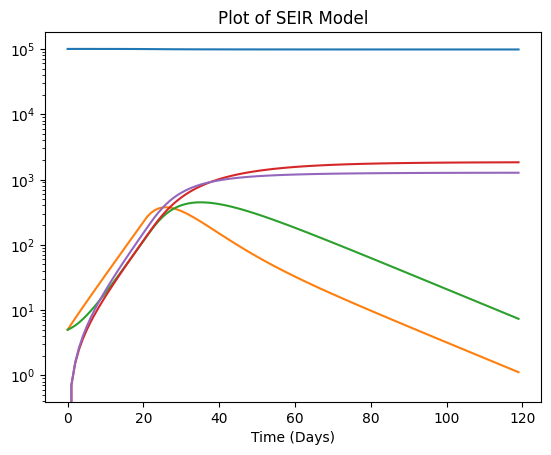

In [3]:
plt.yscale('log')
plt.title('Plot of SEIR Model')
plt.xlabel('Time (Days)')
plt.plot(t_vec,state.T)

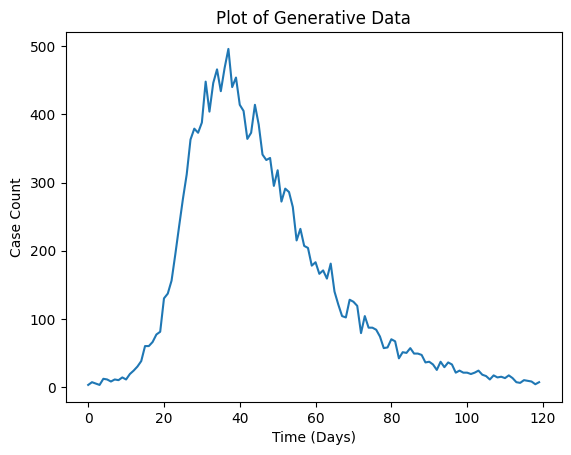

In [4]:
n = 100
sigma = 0.1
rho = 0.4

data = np.expand_dims(rng.poisson(state[2,::int(1/dt)]),0)

plt.title('Plot of Generative Data')
plt.xlabel('Time (Days)')
plt.ylabel('Case Count')
plt.plot(data.T)

In [5]:
def SEIR_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    gamma,eta = model_params

    '''OU Process'''
    sig = 0.5
    lam = 1/100
    mu = -1.9

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_E = rng.poisson((particles[index,4,t] * (particles[index, 1, t] + 0.1 * particles[index, 2, t]) * particles[index, 0, t])/np.sum(particles[index,:,t]) * dt)
        new_I = rng.poisson((eta * particles[index,1,t]) * dt)
        new_ER = rng.poisson((gamma * particles[index,1,t]) * dt)
        new_IR = rng.poisson((gamma * particles[index,2,t]) * dt)
        new_D = rng.poisson((0.004 * particles[index,2,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] - new_E) #S
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_E - new_I - new_ER) #E
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_I - new_IR - new_D) #I
        particles[index,3,t] = np.maximum(0.,particles[index,3,t] + new_ER + new_IR)
        particles[index,4,t] = np.exp(A * np.log(particles[index,4,t]) - M + C * rng.standard_normal())#beta_sim(beta_par,t)#

        observations[index,0,t] = particles[index,2,t]#new_E#particles[:,1,t]

    return particles,observations

def SEIR_Obs(data_point, particle_observations, model_params):
    var = 900
    return -((((data_point - particle_observations[:,0])**2)/(2 * var)) + np.log(np.sqrt(2 * np.pi * var)))


In [6]:

#(0.06547914,0.28245005)
#(1/14 = 0.07,1/7 = 0.14)

def SEIR_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 100_000
    E_I_init = rng.integers(0,5,size = (num_particles * 2)).reshape((num_particles,2))
    particles_0[:,0] -= np.sum(E_I_init,axis = 1)
    particles_0[:,1] = E_I_init[:,0]
    particles_0[:,2] = E_I_init[:,1]
    particles_0[:,4] = rng.uniform(0.,1., size = (num_particles,))
    

    return particles_0

pf_params = {'num_particles':10_000, 
                      'dt':1.,
                      'model':SEIR_model,
                      'observation_model':SEIR_Obs,
                      'model_dim':5,
                      'particle_initializer':SEIR_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= (gamma,eta),
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)


6.401712100021541


 Log Likelihood : -552.4947236770568
Root Mean Squared Error for the Data 148.56407726937508


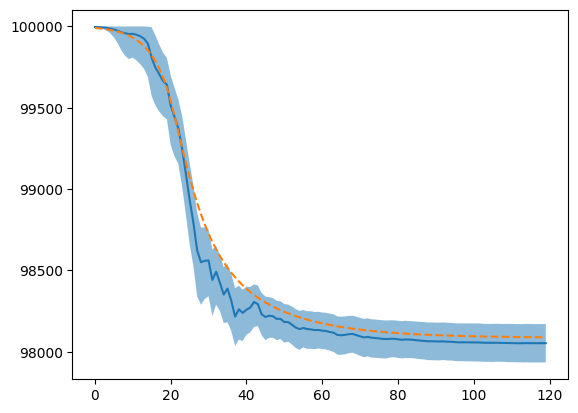

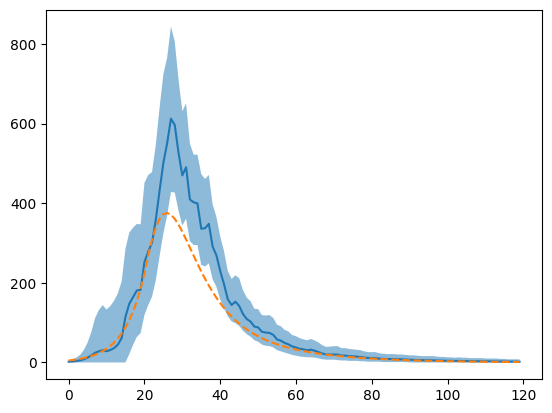

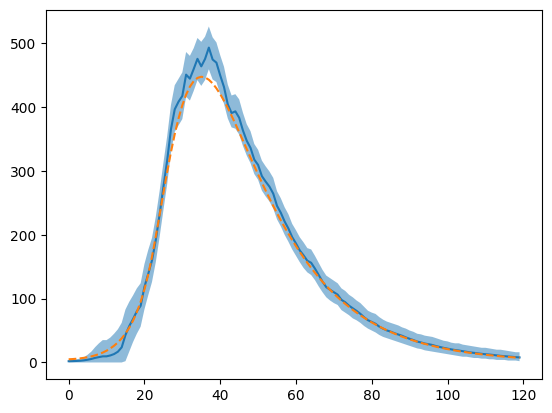

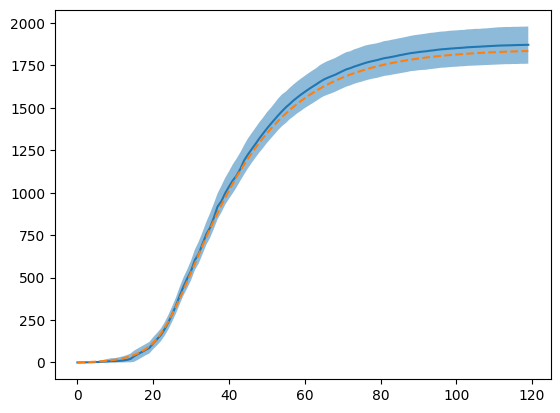

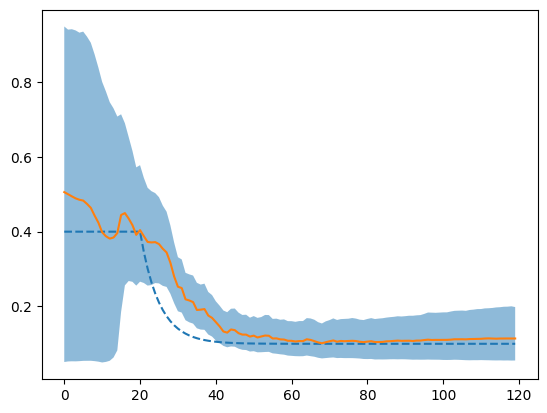

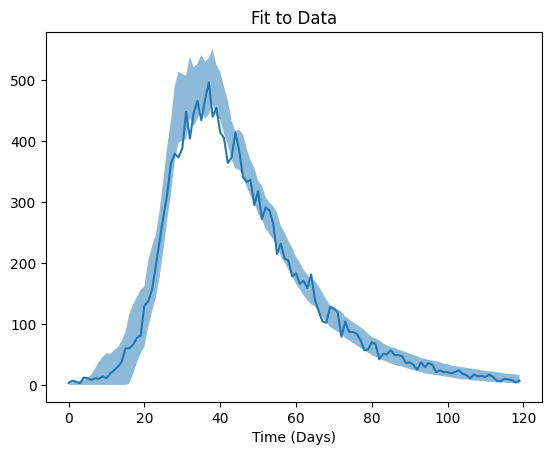

In [7]:
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")

print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

for i in range(4):
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,95,axis = 1),alpha = 0.5)
    plt.plot(np.average(output['particle_distribution'][:,i,:],weights = np.exp(output['log_weights']),axis = 0))
    plt.plot(t_vec,state[i,:].T,'--')
    plt.show()

plt.plot(t_vec,betas,'--')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,95,axis = 1),alpha = 0.5)
plt.plot(np.average(output['particle_distribution'][:,4,:],weights = np.exp(output['log_weights']),axis = 0))
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T)
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,95,axis = 1),alpha = 0.5)
plt.show()


In [9]:
pmcmc_rng = np.random.default_rng(0)

iterations = 10_000

num_particles = 1000

@nb.njit
def uniform_numba_logpdf(theta,min_val,max_val):

    if(theta < max_val and theta > min_val):
        return np.log(1/(max_val - min_val))
    
    return np.log(0.)

def seir_prior(theta):
    return uniform_numba_logpdf(theta[0],min_val= 1/28.,max_val= 1/7) + uniform_numba_logpdf(theta[1],min_val = 1/15.,max_val = 1/3)

pmcmc_params = {'iterations':1000,'init_params':np.array([0.1,0.1,0.01]),'prior':seir_prior,'init_cov':np.eye(3)}

pmcmc_validator(data,pmcmc_params,pf_params,rng,req_jit=False)

# theta, LL, MLE_Particles,MLE_Observations = PMCMC(
#                   data = data,
#                   pmcmc_params,
#                   pf_params
#                   )




functools.partial(<function filter_internal at 0x000001ABFDEBC7C0>, num_particles=10000, dt=1.0, model=CPUDispatcher(<function SEIR_model at 0x000001ABFEB47880>), observation_model=CPUDispatcher(<function SEIR_Obs at 0x000001ABFEB46E80>), model_dim=5, particle_initializer=CPUDispatcher(<function SEIR_init at 0x000001ABFEB47920>))

-496.0622091694664
The Maximum Likelihood Estimate is [0.06442119 0.25740203] w/ LL of -496.0622091694664


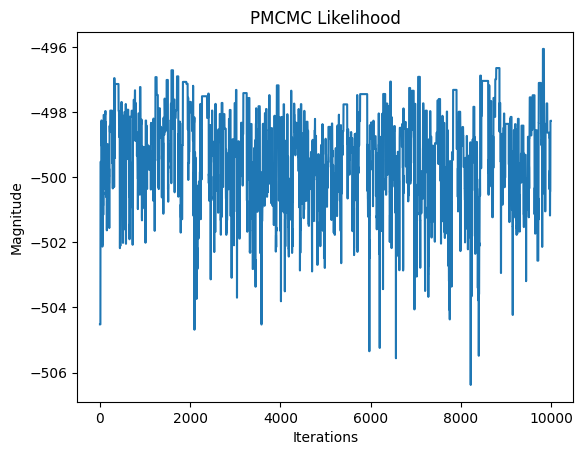

In [ ]:
burn_in = 1000


MLE = np.argmax(LL)

print(LL[MLE])

print(f"The Maximum Likelihood Estimate is {theta[:,MLE]} w/ LL of {LL[MLE]}")

plt.title("PMCMC Likelihood")
plt.ylabel("Magnitude")
plt.xlabel("Iterations")
plt.plot(LL)

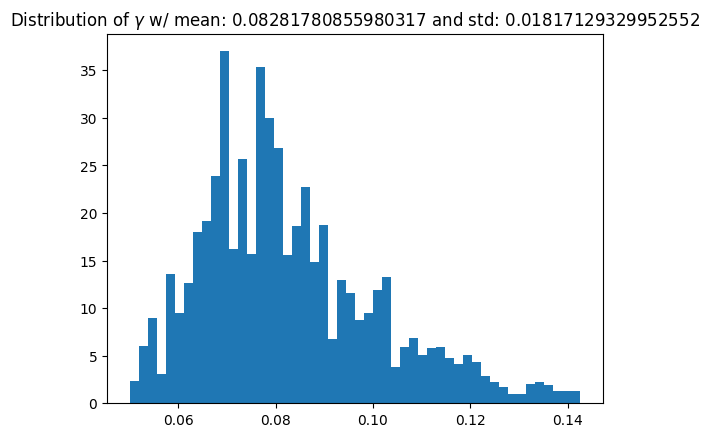

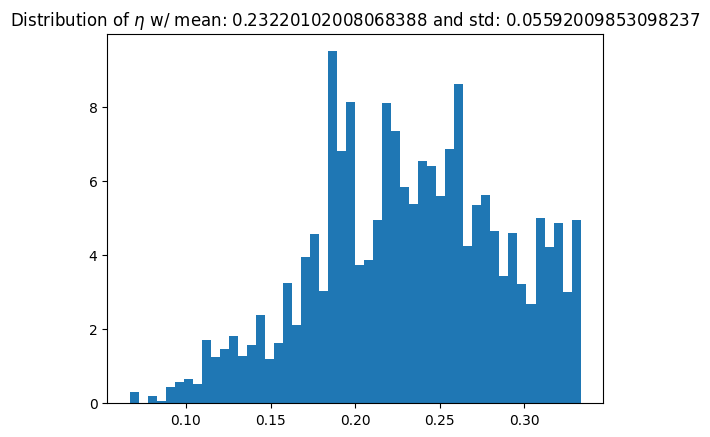

In [ ]:
plt.title(f"Distribution of $\\gamma$ w/ mean: {np.mean(theta[0,burn_in:])} and std: {np.std(theta[0,burn_in:])}")
plt.hist(theta[0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\eta$ w/ mean: {np.mean((theta[1,burn_in:]))} and std: {np.std((theta[1,burn_in:]))}")
plt.hist((theta[1,burn_in:]),density=True,bins = 50)
plt.show()

# plt.title(f"Distribution of OU Param $\\mu$ w/ mean: {np.mean(theta[2,burn_in:])} and std: {np.std(theta[2,burn_in:])}")
# plt.hist(theta[2,burn_in:],density=True,bins = 50)
# plt.show()

# plt.title(f"Distribution of OU Param $\\mu$ w/ mean: {np.mean(theta[3,burn_in:])} and std: {np.std(theta[3,burn_in:])}")
# plt.hist(theta[3,burn_in:],density=True,bins = 50)
# plt.show()




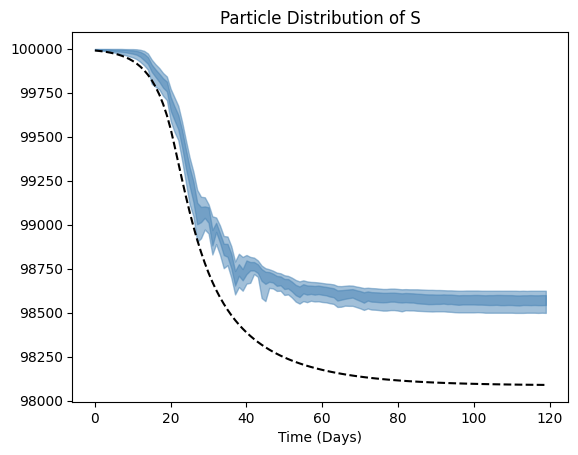

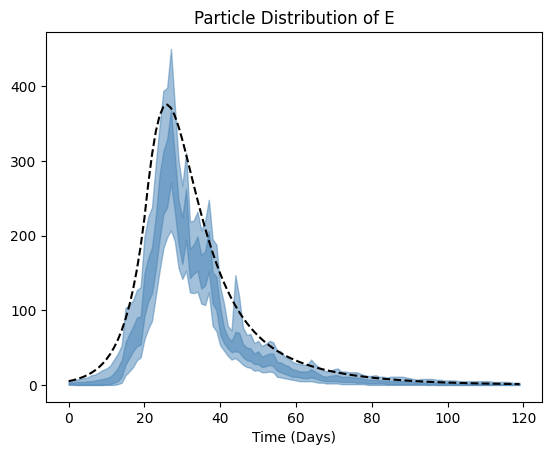

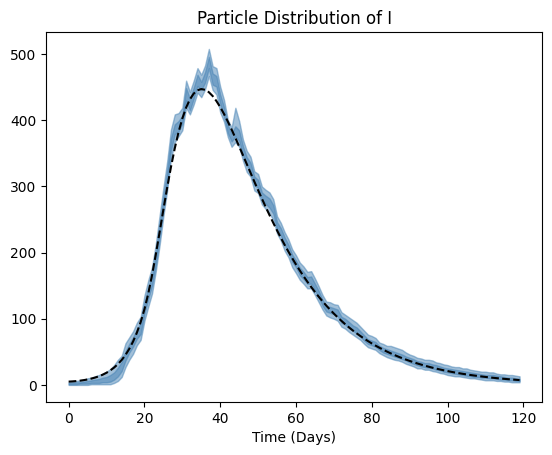

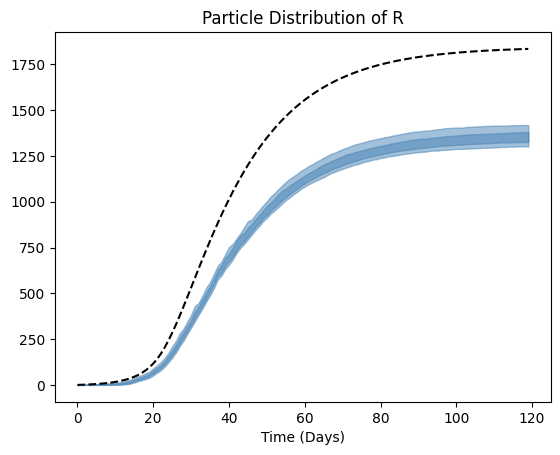

In [ ]:
Labels = ['S','E','I','R']
for i in range(4):
    plt.title(f"Particle Distribution of {Labels[i]}")
    plt.xlabel('Time (Days)')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    #plt.plot(t_vec[::int(1/dt)],[i,:,MLE])
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(MLE_Particles[:,i,:].T,5,axis = 1),np.percentile(MLE_Particles[:,i,:].T,95,axis = 1),alpha = 0.5,color = 'steelblue') 
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(MLE_Particles[:,i,:].T,25,axis = 1),np.percentile(MLE_Particles[:,i,:].T,75,axis = 1),alpha = 0.5,color = 'steelblue') 
    plt.show()

Root Mean Squared Error for the Data 148.4365598397071
Root Mean Squared Error for beta 0.123713456943162


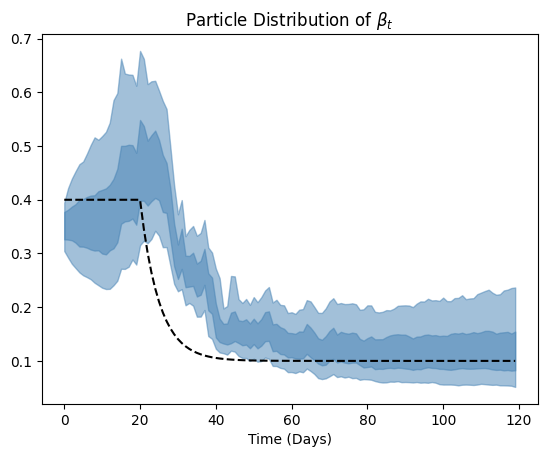

In [ ]:
print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(MLE_Observations[:,0,:]))**2))}")
print(f"Root Mean Squared Error for beta {np.sqrt(np.mean((betas - np.mean(MLE_Particles[:,4,:]))**2))}")
plt.title("Particle Distribution of $\\beta_t$")
plt.xlabel("Time (Days)")
plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(MLE_Particles[:,4,:].T,5,axis = 1),np.percentile(MLE_Particles[:,4,:].T,95,axis = 1),alpha = 0.5,color = 'steelblue') 
plt.fill_between(t_vec[::int(1/dt)],np.percentile(MLE_Particles[:,4,:].T,25,axis = 1),np.percentile(MLE_Particles[:,4,:].T,75,axis = 1),alpha = 0.5,color = 'steelblue') 
plt.show()

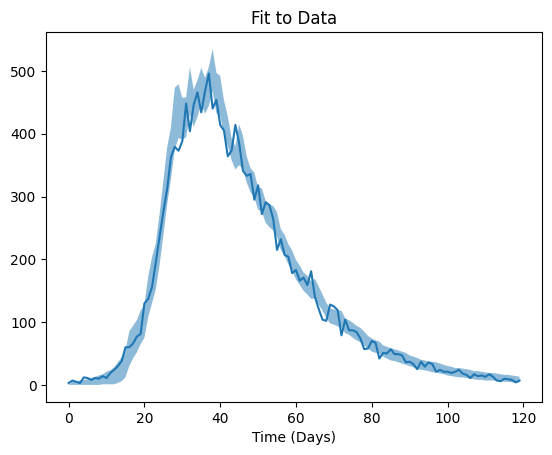

In [ ]:
plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data)
plt.fill_between(t_vec[::int(1/dt)],np.percentile(MLE_Observations[:,0,:].T,5,axis = 1),np.percentile(MLE_Observations[:,0,:].T,95,axis = 1),alpha = 0.5)
plt.show()


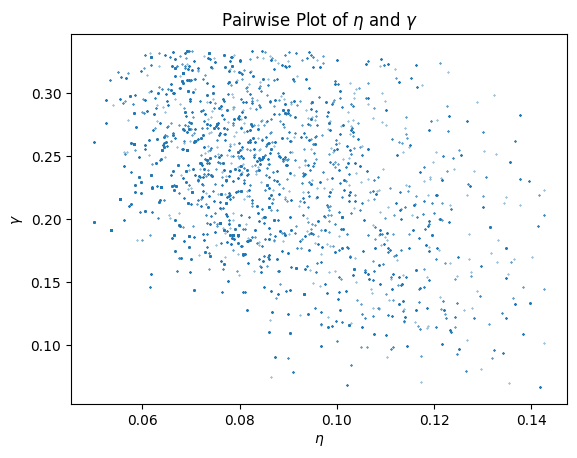

In [ ]:
'''Pair plots'''

plt.title('Pairwise Plot of $\\eta$ and $\\gamma$')
plt.xlabel('$\\eta$')
plt.ylabel('$\\gamma$')
plt.scatter(theta[0,burn_in:],theta[1,burn_in:],s=0.1)

In [ ]:
plt.title('Pairwise Plot of $\\beta_t$ and $\\eta$')
plt.xlabel('$\\beta_t$')
plt.ylabel('$\\eta$')
plt.scatter(particles[0,burn_in:],theta[1,burn_in:],s=0.1)